In [1]:
#############
###IMPORTS###
#############

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from glob import glob
import time
import pandas as pd
import mediapipe as mp
import keras
import tensorflow as tf
import pickle
import math
from scipy.spatial import distance 
import matplotlib.lines as mlines
import matplotlib.cm as cm

Using TensorFlow backend.


In [2]:
##########################
###GPU INFERENCE CONFIG###
##########################

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [3]:
############################
###USER DEFINED VARIABLES###
############################
print('Type left_wrist or right_wrist to analyze one of them \n')
wrist_to_analyze = input()
print('Type the name of the experiment to analyze \n')
experiment = input()
print('Type the number of iterations you want to perform for the wrist')
n_test = int(input())


Type left_wrist or right_wrist to analyze one of them 

right_wrist
Type the name of the experiment to analyze 

noise_lvl1
Type the number of iterations you want to perform for the wrist
1


In [4]:
###############
###VARIABLES###
###############

#Initialize the Mediapipe module with its corresponding parameters
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(model_complexity=1,min_detection_confidence=0.5,min_tracking_confidence=0.5, static_image_mode=True)

#NN initialization 
model = keras.models.load_model('../../solutions/Martinez/models/Non_Gravity/'+experiment+'/model.h5')
scaler_2D = pickle.load(open('../../solutions/Martinez/models/Non_Gravity/'+experiment+'/scaler_2D.pkl','rb'))
scaler_3D = pickle.load(open('../../solutions/Martinez/models/Non_Gravity/'+experiment+'/scaler_3D.pkl','rb'))

#Setup RGSClinic 15º tilt

markers_gt_coordinates = np.array([
    [-0.035999950021505356,  0.841], 
    
    [-0.21099995076656342,  0.871],
    [-0.2749999463558197,  0.697],
    [-0.35999995470046997, 0.897], 
    [-0.47099995613098145,  0.772], 
    
    [0.20200004935264587, 0.870],
    [0.26200006663799286, 0.681],
    [0.3290000343322754, 0.870],
    [0.41900004863739014, 0.780],   
])

#Select the number of keypoints to detect 
number_keypoints_to_detect = 6

#Select the indices of the landmarks of interest to detect from the output of the previous cell
indices_landmark_interest = [11, 12, 13, 14, 15 ,16]

In [5]:
###############
###FUNCTIONS###
###############

#Function that allows to select the wrist coordinates regarding left or right arm. 
#The index correspond to the predicted list where the order is: [right_shoulder, right_elbow, right_wrist, left_shoulder, left_elbow, left_wrist]
def index_to_select(wrist):
    if wrist == 'right_wrist':
        mediapipe_index = 2
    else:
        mediapipe_index = 5      
    return(mediapipe_index)

def markers_to_analyze(wrist):
    if wrist =='right_wrist':
        markers_to_analyze = [0,1,2,3,4,5,6]
    else:
        markers_to_analyze = [0,1,2,5,6,7,8]
    return(markers_to_analyze)
        

def markers_drawing(wrist):
    if wrist =='right_wrist':
        circle_list= [
            (977,719),
            (1274,743),
            (1333,455),
            (1517,828),
            (1670, 625),
            (683,777),
            (598,502)]
    else:
        circle_list = [
            (977,719),
            (1274,743),
            (1333,455),
            (683,777),
            (598,502),
            (426,892),
             (259,693)]
        
    return(circle_list)

def split_3_coordinates_array(array):
    m = 0
    r = 3
    splitted_coords = []
    for i in range(0,int(len(array)/3)):
        splitted_coords.append(array[m:r])
        m = r
        r = r+3
    return(np.array(splitted_coords))

def mediapipe_inference(frame):
    results = pose.process(frame)
    frame_list1 = []
    point_coords_landmark_interest = []
    start_index = 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            if start_index in indices_landmark_interest:
                image_hight, image_width, _ = frame.shape
                frame_list1.append(landmark.x*image_width)
                frame_list1.append(landmark.y*image_hight)
                point_coords_landmark_interest.append((int(round(landmark.x*image_width)),int(round(landmark.y*image_hight))))
                start_index = start_index+1
            else: 
                start_index = start_index+1 

    return(frame_list1,frame)


In [6]:
######################
###METRIC PROCEDURE###
######################

#Only 7 markers are analyzed for each wrist. Oposite-extrem ones to the wrist are not considered. 
gamming_image = cv2.imread('./gamming_zone.jpg')

#Llista on hi haurà n_test arrays differents de 12,2 shape. 
n_test_performed_list_results = []

for j in range(0,n_test):
    markers_pred_coordinates = np.zeros([7,2])
    df = pd.DataFrame(columns=np.arange(0,12,1))
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
    if cap.isOpened():
        for i in range(0,len(markers_pred_coordinates)):
            try:  
                marker_numbers = markers_to_analyze(wrist_to_analyze)
                circle_list = markers_drawing(wrist_to_analyze)
                gamming_image = cv2.circle(gamming_image, circle_list[i], radius=75, color =(0,255,0),thickness=-1)
                gamming_image = cv2.putText(gamming_image, str(i+1), (circle_list[i][0]-20,circle_list[i][1]+20), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(255,0,0), thickness = 12)

                cv2.imshow('Guide', gamming_image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

                print('Put your wrist on marker number '+str(marker_numbers[i]+1))
                time.sleep(1.5)
                sucess,frame = cap.read()
                frame = cv2.resize(frame,(1920,1080))
                frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                frame.flags.writeable = False

                #MediaPipe inference
                detected_keypoints,frame  = mediapipe_inference(frame)

                #Saving image processed by MediaPipe
                frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
                cv2.imwrite('./output/frames/frame_'+str(j+1)+'_'+str(i+1)+'.jpg',frame)
                
                df = df.append(pd.DataFrame(detected_keypoints).T)
                df = df[[2,3,6,7,10,11,0,1,4,5,8,9]] #Reordeno para tener el orden de la NN

                #NN inference
                X = np.array([list(df.iloc[i])]).astype(float)
                X_scaled = scaler_2D.transform(X)
                z_predicted = np.float32(model.predict(X_scaled) *scaler_3D.scale_ + scaler_3D.mean_)
                z_predicted_splitted = split_3_coordinates_array(z_predicted[0])
                print(z_predicted_splitted)
                markers_pred_coordinates[i] = np.array([z_predicted_splitted[index_to_select(wrist_to_analyze)][0], z_predicted_splitted[index_to_select(wrist_to_analyze)][2]])

            except KeyboardInterrupt:
                print('Camera is closed')
                cap.release() 
                
                
        n_test_performed_list_results.append(markers_pred_coordinates)

    print('Process Finished')
    cap.release()
    cv2.destroyAllWindows()
    gamming_image = cv2.imread('./gamming_zone.jpg')
    



Put your wrist on marker number 1
[[-0.08583664  0.12579976  1.1460499 ]
 [-0.16059151 -0.11972498  1.0253812 ]
 [ 0.01779214 -0.20021167  0.87606263]
 [ 0.24008167  0.14703946  1.2105231 ]
 [ 0.36963364 -0.05679471  1.1867715 ]
 [ 0.32898274 -0.17469831  0.9683028 ]]
Put your wrist on marker number 2
[[-0.09636737  0.16911145  1.2120447 ]
 [-0.21028015 -0.02555026  1.0939221 ]
 [-0.18201277 -0.15937996  0.93334275]
 [ 0.23330298  0.13309972  1.2052878 ]
 [ 0.31821713 -0.04591737  1.0594194 ]
 [ 0.32641158 -0.16890949  0.8930958 ]]
Put your wrist on marker number 3
[[-0.11285583  0.11147299  1.1343406 ]
 [-0.23637627 -0.08478072  0.9823156 ]
 [-0.24562119 -0.23625357  0.78831255]
 [ 0.22546056  0.11446943  1.1908857 ]
 [ 0.34451464 -0.06811012  1.1145164 ]
 [ 0.33655262 -0.18491775  0.91431934]]
Put your wrist on marker number 4
[[-0.10324898  0.15292454  1.192045  ]
 [-0.2493893  -0.02575293  1.0943478 ]
 [-0.2781059  -0.15600123  0.9333365 ]
 [ 0.2261634   0.10760606  1.1809354 ]
 [ 

In [12]:
###################################
### COMPUTING EUCLIDEAN DISTANCE###
###################################

#Select just the ground-truth markers based on which wrist is being analyzed
final_markers_gt_coordinates = []
marker_numbers = markers_to_analyze(wrist_to_analyze)
for marker in marker_numbers:
    final_markers_gt_coordinates.append(markers_gt_coordinates[marker])
final_markers_gt_coordinates = np.array(final_markers_gt_coordinates)

#Euclidean distance list containing n_test times the euclidean distance computed between ground-truth and predicted values
n_euc_results = []
for array in n_test_performed_list_results:
    euc_results = []
    for i in range(0,len(final_markers_gt_coordinates)):
        euc_results.append(distance.euclidean(array[i],final_markers_gt_coordinates[i]))
    n_euc_results.append(euc_results)

#Smoothing euclidean distance results
n_final_results = []
for euc_array in n_euc_results:
    final_results = []
    for result in euc_array:
        corrected_result = result-0.03
        if corrected_result < 0:
            corrected_result = 0.0
        else:
            pass
        final_results.append(corrected_result)  
    n_final_results.append(final_results)


print('The mean error in [cm] is: '+str(sum(n_final_results[0])/len(n_final_results[0])*100))
print('The std in [cm] is: ' +str(pd.DataFrame(n_final_results[0]).std()[0]*100))

The mean error in [cm] is: 17.081942460314384
The std in [cm] is: 19.153312952293216


In [16]:
n_test_performed_list_results[0]*100

array([[  1.77921355,  87.60626316],
       [-18.20127666,  93.33427548],
       [-24.56211895,  78.83125544],
       [-27.81059146,  93.33364964],
       [-27.51560807,  91.57334566],
       [-39.34039772,  83.1897974 ],
       [ 20.73943317,  92.26136804]])

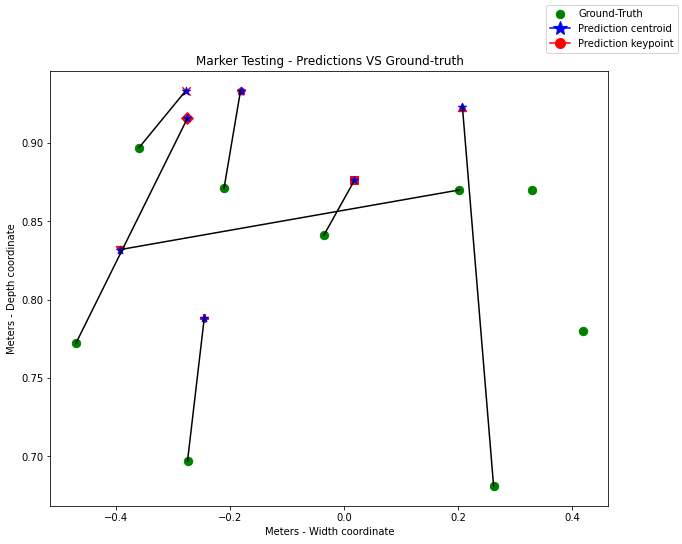

In [17]:
#######################################
###PROJECTING ERROR VS GT UPON TABLE###
#######################################

markers_type = ['s','p','P','x','D','v','^']
final_array = np.array(n_test_performed_list_results)
fig = plt.figure(figsize=(10,8))

#Plotting ground-truth values
plt.scatter(markers_gt_coordinates[:,0],markers_gt_coordinates[:,1], color='green', s=70,label='Ground-Truth')

#Plotting predictions
for test_performed in n_test_performed_list_results:
    for i in range(0,len(test_performed)):
        plt.scatter(test_performed[i,0], test_performed[i,1], color='red',s=70, marker=markers_type[i])

#Computing centroid and plotting it
predicted_markers_centroid_coordinates = []
for i in range(0,7):
    centroid_coordinates = (sum(final_array[:,i,0])/len(final_array[:,i,0]), sum(final_array[:,i,1])/len(final_array[:,i,1]))
    predicted_markers_centroid_coordinates.append(centroid_coordinates)
    plt.scatter(centroid_coordinates[0], centroid_coordinates[1], color='blue', s=70, marker='*')

centroid_euc_results = []
for i in range(0,len(final_markers_gt_coordinates)):
    centroid_euc_results.append(distance.euclidean(predicted_markers_centroid_coordinates[i],final_markers_gt_coordinates[i]))    

#Lines between GT markers and Centroids
markers_gt_coordinates_splitted = markers_gt_coordinates[marker_numbers]
for i in range(0,len(centroid_euc_results)):
        plt.plot([markers_gt_coordinates_splitted[i][0],predicted_markers_centroid_coordinates[i][0]], [markers_gt_coordinates_splitted[i][1],predicted_markers_centroid_coordinates[i][1]], color='black')

plt.title('Marker Testing - Predictions VS Ground-truth')
plt.ylabel('Meters - Depth coordinate')
plt.xlabel('Meters - Width coordinate')

handles, labels = plt.gca().get_legend_handles_labels()
blue_star = mlines.Line2D([], [], color='blue', marker='*',markersize=15, label='Prediction centroid')
red_dot = mlines.Line2D([], [], color='red', marker='.',markersize=20, label='Prediction keypoint')
handles.extend([blue_star, red_dot])
fig.legend(handles=handles)
plt.savefig('./output/error_projection.jpg')
